# Air quality comparison in Turin during 2020
Comparing Google mobility data with air quality data provided by regional autority (ARPA).

In [153]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import dates

## Mobility Dataset:

### Reading mobility data 
Provided by: <br>
Google LLC "Google COVID-19 Community Mobility Reports".
https://www.google.com/covid19/mobility/ 

In [154]:
palette = ["blue","red","green","orange","purple","brown"]
labels=['Retail & Recreation','Grocery & Pharmacy','Parks','Transit stations','Workplaces','Residential']
positions = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']


def get_to_mobility_data(path):
    data = pd.read_csv(path, parse_dates=['date'])
    #Filtering by sub_region
    data = data[data['sub_region_2'] == 'Metropolitan City of Turin'].copy()
    #remove empty column
    data.dropna(how='all', axis=1, inplace=True)
    return data





## Mobility Data 2020

In [155]:
to_mobility_data_2020 = get_to_mobility_data('data/Mobility/2020_IT_Region_Mobility_Report.csv')


### Descriptive Statistics

In [156]:
to_mobility_data_2020.describe(include=[float])

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,-38.239875,-20.043614,-12.074766,-43.903427,-34.710280,12.439252
std,26.433438,20.420072,38.484583,21.029147,21.068197,11.042682
min,-96.000000,-96.000000,-92.000000,-91.000000,-92.000000,-7.000000
25%,-57.000000,-27.000000,-35.000000,-56.000000,-48.000000,4.000000
50%,-29.000000,-15.000000,-9.000000,-40.000000,-33.000000,9.000000
75%,-17.000000,-8.000000,19.000000,-29.000000,-23.000000,19.000000
max,3.000000,40.000000,110.000000,4.000000,14.000000,46.000000


### Multi-Line plot

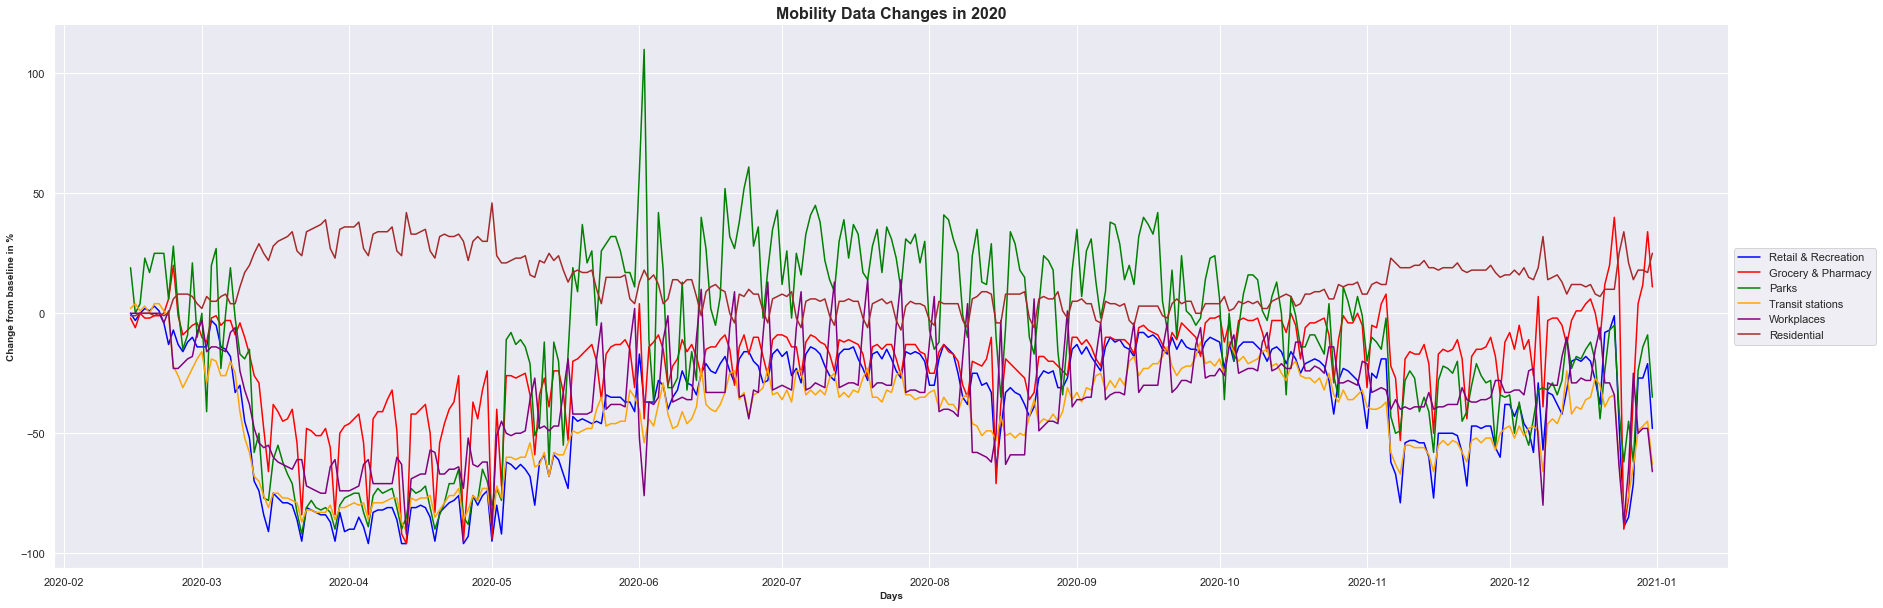

In [157]:
#set seaborn grapichs theme
sns.set_theme()

plt.figure(figsize=(30, 10))




# create a color palette
#palette = plt.get_cmap('Paired')

num = 0
plots =[]

for y in positions:
    line = to_mobility_data_2020[y]
    p = plt.plot(to_mobility_data_2020.date,line, label=labels[num], color=palette[num])
    plots += p
    num+=1

plt.xlabel('Days',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.ylabel('Change from baseline in %',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.legend(handles=plots)
plt.title("Mobility Data Changes in 2020",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
sns.despine()
plt.show()

#### Rename columns

In [158]:
to_mobility_data_2020= to_mobility_data_2020.rename(columns = {'retail_and_recreation_percent_change_from_baseline':labels[0], 'grocery_and_pharmacy_percent_change_from_baseline':labels[1],
                                    'parks_percent_change_from_baseline':labels[2],'transit_stations_percent_change_from_baseline':labels[3],
                                    'workplaces_percent_change_from_baseline':labels[4],'residential_percent_change_from_baseline':labels[5],})
# Remove all columns between column index 1 to 6
to_mobility_data_2020.drop(to_mobility_data_2020.iloc[:, 0:6], inplace = True, axis = 1)

## Mobility Data 2021

In [159]:
to_mobility_data_2021 = get_to_mobility_data('data/Mobility/2021_IT_Region_Mobility_Report.csv')


### Descriptive Statistics

In [160]:
to_mobility_data_2021.describe(include=[float])

,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline
count,365.000000,365.000000
mean,4.602740,-33.898630
std,25.894195,12.438999
min,-78.000000,-85.000000
25%,-15.000000,-43.000000
50%,6.000000,-31.000000
75%,26.000000,-24.000000
max,76.000000,-5.000000


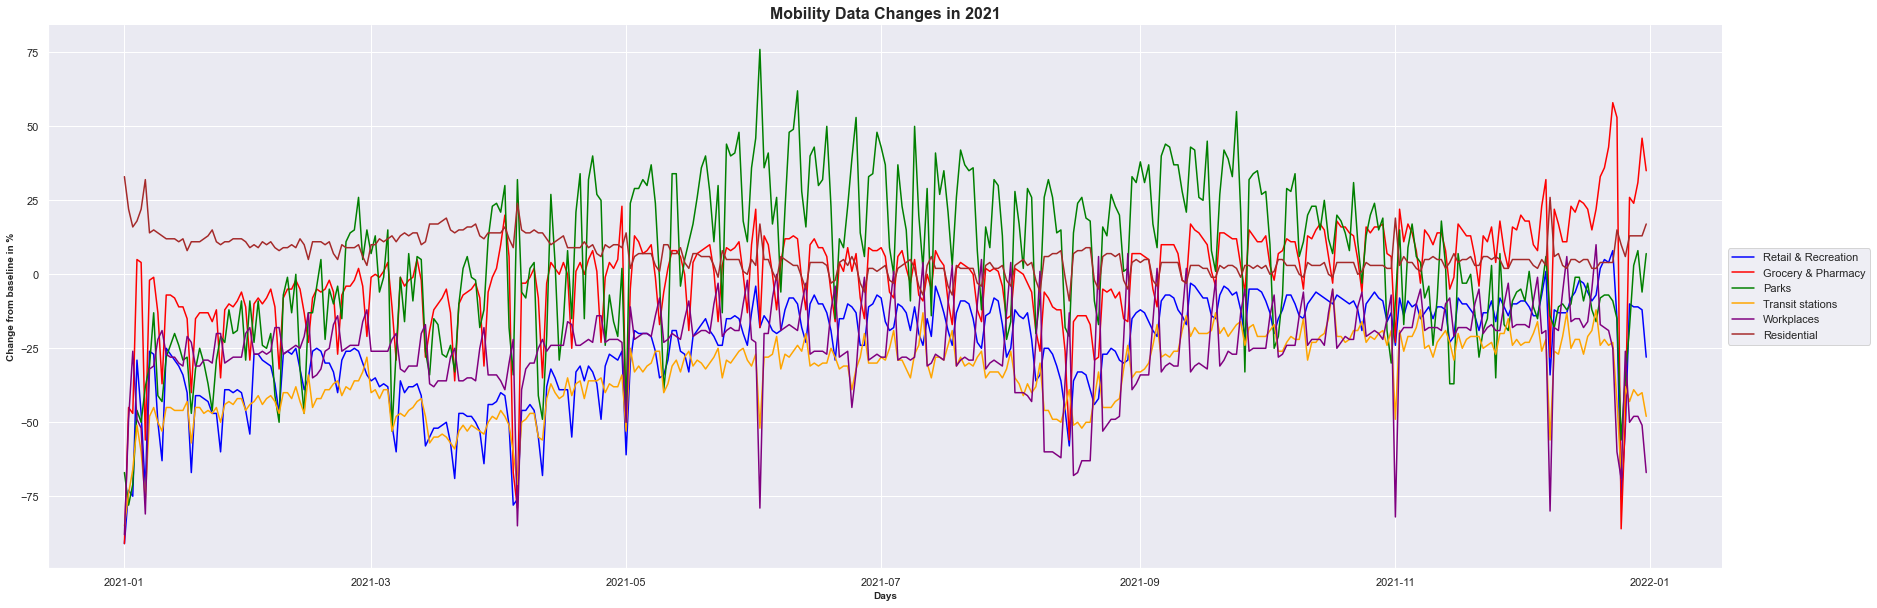

In [161]:
#set seaborn grapichs theme
sns.set_theme()

plt.figure(figsize=(30, 10))


num = 0
plots =[]

for y in positions:
    line = to_mobility_data_2021[y]
    p = plt.plot(to_mobility_data_2021.date,line, label=labels[num], color=palette[num])
    plots += p
    num+=1

plt.xlabel('Days',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.ylabel('Change from baseline in %',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.legend(handles=plots)
plt.title("Mobility Data Changes in 2021",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
sns.despine()
plt.show()

#### Rename columns

In [162]:
to_mobility_data_2021= to_mobility_data_2021.rename(columns = {'retail_and_recreation_percent_change_from_baseline':labels[0], 'grocery_and_pharmacy_percent_change_from_baseline':labels[1],
                                    'parks_percent_change_from_baseline':labels[2],'transit_stations_percent_change_from_baseline':labels[3],
                                    'workplaces_percent_change_from_baseline':labels[4],'residential_percent_change_from_baseline':labels[5],})
# Remove all columns between column index 1 to 6
to_mobility_data_2021.drop(to_mobility_data_2021.iloc[:, 0:6], inplace = True, axis = 1)

## Air Quality Dataset:

### Reading ARPA data 
Provided by: <br>
Arpa Piemonte <br>
Dipartimento Rischi naturali e ambientali <br>
https://aria.ambiente.piemonte.it/

In [163]:
def read_ARPA_csv(path):
    dataFrame = pd.read_csv(path, sep=';',dtype={'Data rilevamento': str, 'Ora':str},index_col=False ) 

    #merge date and hours and parsing
    dataFrame["Data rilevamento"] = dataFrame["Data rilevamento"] + " " +  dataFrame["Ora"]
    dataFrame["Data rilevamento"] = pd.to_datetime(dataFrame["Data rilevamento"], format='%d/%m/%Y %H:%M') 
    return dataFrame

def get_daily_data(path,start_date):
    initial_data=read_ARPA_csv(path)
    #group by day
    data_daily = initial_data.resample('D', on='Data rilevamento').mean()
    data_daily = data_daily[(data_daily.index.get_level_values('Data rilevamento') >= start_date)]     
    data_daily.reset_index(inplace=True)

    return data_daily

def get_daily_adjusted_data(basePath, year):
  yearly_data = []

  #getting all the dataset
  for x in range(2012, 2020):
    data = get_daily_data(basePath +'_' + str(x) + '-01-01_' + str(x) + '-12-31.csv',str(x) + '-01-01 ')[['Data rilevamento','Valore']]
    #take only the day of the year
    data['Data rilevamento']= data['Data rilevamento'].dt.dayofyear
    yearly_data.append(data)

  #create daily baseline
  avg_daily_baseline=pd.concat([yearly_data[0],yearly_data[1],yearly_data[2],yearly_data[3],yearly_data[4],yearly_data[5],yearly_data[6],yearly_data[7]]).groupby('Data rilevamento', as_index=True).mean()
  avg_daily_baseline.reset_index(inplace = True)
  
  #get yearly data
  yearly_data = get_daily_data(basePath + '_' + year + '-01-01_' + year + '-12-31.csv', year + '-01-01')[['Data rilevamento','Valore']]
  yearly_data['Giorno']= yearly_data['Data rilevamento'].dt.dayofyear
  
  yearly_data.set_index('Giorno')
  avg_daily_baseline.set_index('Data rilevamento')

  #calculate percentage deviation
  return_data = yearly_data
  return_data['Valore'] = ((yearly_data['Valore']-avg_daily_baseline['Valore'])/avg_daily_baseline['Valore'])*100

  #resetting index
  return_data.set_index('Data rilevamento')
  
  #remove nan column and useless column
  return_data.dropna(inplace=True)
  del return_data['Giorno']
  if 'Id Un. misura' in return_data.columns:
    del return_data['Id Un. misura']
  
  return return_data

### Get Air Quality Data 2020

#### PM10

In [164]:
consolata_pm10_2020=get_daily_adjusted_data('data/ARPA/PM10/Consolata/Torino-Consolata_Polveri-sottili','2020')
rebaudengo_pm10_2020 = get_daily_adjusted_data('data/ARPA/PM10/Rebaudengo/Torino-Rebaudengo_Polveri-sottili','2020')
lingotto_pm10_2020 = get_daily_adjusted_data('data/ARPA/PM10/Lingotto/Torino-Lingotto_Polveri-sottili','2020')
rubino_pm10_2020 = get_daily_adjusted_data('data/ARPA/PM10/Rubino/Torino-Rubino_Polveri-sottili','2020')
grassi_pm10_2020 =get_daily_adjusted_data('data/ARPA/PM10/Grassi/Torino-Grassi_Polveri-sottili','2020')
avg_turin_pm10_2020=pd.concat([rebaudengo_pm10_2020,consolata_pm10_2020,lingotto_pm10_2020,rubino_pm10_2020,grassi_pm10_2020]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_pm10_2020.rename(columns = {'Valore':'PM10'}, inplace = True)

#### NOx

In [165]:
consolata_nox_2020=get_daily_adjusted_data('data/ARPA/NOx/Consolata/Torino-Consolata_Gas','2020')
rebaudengo_nox_2020 = get_daily_adjusted_data('data/ARPA/NOx/Rebaudengo/Torino-Rebaudengo_Gas','2020')
lingotto_nox_2020 = get_daily_adjusted_data('data/ARPA/NOx/Lingotto/Torino-Lingotto_Gas','2020')
rubino_nox_2020 = get_daily_adjusted_data('data/ARPA/NOx/Rubino/Torino-Rubino_Gas','2020')
avg_turin_nox_2020=pd.concat([consolata_nox_2020,rebaudengo_nox_2020,lingotto_nox_2020,rubino_nox_2020]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_nox_2020.rename(columns = {'Valore':'NOx'}, inplace = True)

#### NO

In [166]:
consolata_no_2020 = get_daily_adjusted_data('data/ARPA/NO/Consolata/Torino-Consolata_Monossido','2020')
rebaudengo_no_2020 = get_daily_adjusted_data('data/ARPA/NO/Rebaudengo/Torino-Rebaudengo_Monossido','2020')
lingotto_no_2020 = get_daily_adjusted_data('data/ARPA/NO/Lingotto/Torino-Lingotto_Monossido','2020')
rubino_no_2020 = get_daily_adjusted_data('data/ARPA/NO/Rubino/Torino-Rubino_Monossido','2020')
avg_turin_no_2020 = pd.concat([consolata_no_2020,rebaudengo_no_2020,lingotto_no_2020,rubino_no_2020]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_no_2020.rename(columns = {'Valore':'NO'}, inplace = True)


#### NO2

In [167]:
consolata_no2_2020 = get_daily_adjusted_data('data/ARPA/NO2/Consolata/Torino-Consolata_Biossido','2020')
rebaudengo_no2_2020 = get_daily_adjusted_data('data/ARPA/NO2/Rebaudengo/Torino-Rebaudengo_Biossido','2020')
lingotto_no2_2020 = get_daily_adjusted_data('data/ARPA/NO2/Lingotto/Torino-Lingotto_Biossido','2020')
rubino_no2_2020 = get_daily_adjusted_data('data/ARPA/NO2/Rubino/Torino-Rubino_Biossido','2020')
avg_turin_no2_2020 = pd.concat([consolata_no2_2020,rebaudengo_no2_2020,lingotto_no2_2020,rubino_no2_2020]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_no2_2020.rename(columns = {'Valore':'NO2'}, inplace = True)


#### Benzene

In [168]:
consolata_bnz_2020 = get_daily_adjusted_data('data/ARPA/Benzene/Consolata/Torino-Consolata_Idrocarburi-aromatici','2020')
rebaudengo_bnz_2020 = get_daily_adjusted_data('data/ARPA/Benzene/Rebaudengo/Torino-Rebaudengo_Idrocarburi-aromatici','2020')
lingotto_bnz_2020 = get_daily_adjusted_data('data/ARPA/Benzene/Lingotto/Torino-Lingotto_Idrocarburi-aromatici','2020')
rubino_bnz_2020 = get_daily_adjusted_data('data/ARPA/Benzene/Rubino/Torino-Rubino_Idrocarburi-aromatici','2020')
avg_turin_bnz_2020  =pd.concat([consolata_bnz_2020,rebaudengo_bnz_2020,lingotto_bnz_2020,rubino_bnz_2020]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_bnz_2020.rename(columns = {'Valore':'Benzene'}, inplace = True)


### Get Air Quality Data 2021

#### PM10

In [169]:
consolata_pm10_2021=get_daily_adjusted_data('data/ARPA/PM10/Consolata/Torino-Consolata_Polveri-sottili','2021')
rebaudengo_pm10_2021 = get_daily_adjusted_data('data/ARPA/PM10/Rebaudengo/Torino-Rebaudengo_Polveri-sottili','2021')
lingotto_pm10_2021 = get_daily_adjusted_data('data/ARPA/PM10/Lingotto/Torino-Lingotto_Polveri-sottili','2021')
rubino_pm10_2021 = get_daily_adjusted_data('data/ARPA/PM10/Rubino/Torino-Rubino_Polveri-sottili','2021')
grassi_pm10_2021 =get_daily_adjusted_data('data/ARPA/PM10/Grassi/Torino-Grassi_Polveri-sottili','2021')
avg_turin_pm10_2021=pd.concat([rebaudengo_pm10_2021,consolata_pm10_2021,lingotto_pm10_2021,rubino_pm10_2021,grassi_pm10_2021]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_pm10_2021.rename(columns = {'Valore':'PM10'}, inplace = True)

#### NOx

In [170]:
consolata_nox_2021 = get_daily_adjusted_data('data/ARPA/NOx/Consolata/Torino-Consolata_Gas','2021')
rubino_nox_2021 = get_daily_adjusted_data('data/ARPA/NOx/Rubino/Torino-Rubino_Gas','2021')
avg_turin_nox_2021 = pd.concat([consolata_nox_2021,rubino_nox_2021]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_nox_2021.rename(columns = {'Valore':'NOx'}, inplace = True)


#### NO

In [171]:
consolata_no_2021 = get_daily_adjusted_data('data/ARPA/NO/Consolata/Torino-Consolata_Monossido','2021')
rebaudengo_no_2021 = get_daily_adjusted_data('data/ARPA/NO/Rebaudengo/Torino-Rebaudengo_Monossido','2021')
lingotto_no_2021 = get_daily_adjusted_data('data/ARPA/NO/Lingotto/Torino-Lingotto_Monossido','2021')
rubino_no_2021 = get_daily_adjusted_data('data/ARPA/NO/Rubino/Torino-Rubino_Monossido','2021')
avg_turin_no_2021 = pd.concat([consolata_no_2021,rebaudengo_no_2021,lingotto_no_2021,rubino_no_2021]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_no_2021.rename(columns = {'Valore':'NO'}, inplace = True)


#### NO2

In [172]:
consolata_no2_2021 = get_daily_adjusted_data('data/ARPA/NO2/Consolata/Torino-Consolata_Biossido','2021')
rebaudengo_no2_2021 = get_daily_adjusted_data('data/ARPA/NO2/Rebaudengo/Torino-Rebaudengo_Biossido','2021')
lingotto_no2_2021 = get_daily_adjusted_data('data/ARPA/NO2/Lingotto/Torino-Lingotto_Biossido','2021')
rubino_no2_2021 = get_daily_adjusted_data('data/ARPA/NO2/Rubino/Torino-Rubino_Biossido','2021')
avg_turin_no2_2021 = pd.concat([consolata_no2_2021,rebaudengo_no2_2021,lingotto_no2_2021,rubino_no2_2021]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_no2_2021.rename(columns = {'Valore':'NO2'}, inplace = True)


#### Benzene

In [173]:
consolata_bnz_2021 = get_daily_adjusted_data('data/ARPA/Benzene/Consolata/Torino-Consolata_Idrocarburi-aromatici','2021')
rebaudengo_bnz_2021 = get_daily_adjusted_data('data/ARPA/Benzene/Rebaudengo/Torino-Rebaudengo_Idrocarburi-aromatici','2021')
lingotto_bnz_2021 = get_daily_adjusted_data('data/ARPA/Benzene/Lingotto/Torino-Lingotto_Idrocarburi-aromatici','2021')
rubino_bnz_2021 = get_daily_adjusted_data('data/ARPA/Benzene/Rubino/Torino-Rubino_Idrocarburi-aromatici','2021')
avg_turin_bnz_2021 = pd.concat([consolata_bnz_2021,rebaudengo_bnz_2021,lingotto_bnz_2021,rubino_bnz_2021]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_bnz_2021.rename(columns = {'Valore':'Benzene'}, inplace = True)


### Reading Weather data 2020
Provided by: <br>
Arpa Piemonte <br>
Dipartimento Rischi naturali e ambientali <br>
https://aria.ambiente.piemonte.it/

In [174]:
def read_ARPA_csv(path):
    dataFrame = pd.read_csv(path, sep=';',dtype={'Data': str},index_col=False ) 

    #merge date and hours and parsing
    dataFrame["Data"] = dataFrame["Data"]
    dataFrame["Data"] = pd.to_datetime(dataFrame["Data"], format='%d/%m/%Y') 
    #removing unamed column
    dataFrame = dataFrame.loc[:, ~dataFrame.columns.str.contains('^Unnamed')]
    #Removing empty column
    dataFrame.dropna(how='all', axis=1, inplace=True)
    
    return dataFrame

def get_average_2012_2019():
    yearly_data = []

    #getting all the dataset
    for x in range(2012, 2020):
        data = read_ARPA_csv('data/Weather/TORINO_VIA_DELLA_CONSOLATA_giornalieri_' + str(x) + '.csv')[['Data','Precipitazione dalle 9 alle 9 ( mm )','Precipitazione dalle 0 alle 0 ( mm )','Temperatura media ( °C )','Temperatura massima ( °C )','Temperatura minima ( °C )',"Umidita' media ( % )","Umidita' massima ( % )","Umidita' minima ( % )","Velocita' media ( m/s )",'Raffica ( m/s )','Durata Calma ( min )','Tempo Permanenza ( min )', 'Radiazione totale ( MJ/mq )']]
        #take only the day of the year
        data['Data']= data['Data'].dt.dayofyear
        yearly_data.append(data)

    #create daily baseline
    avg_daily_baseline=pd.concat([yearly_data[0],yearly_data[1],yearly_data[2],yearly_data[3],yearly_data[4],yearly_data[5],yearly_data[6],yearly_data[7]]).groupby('Data', as_index=True).mean()
    avg_daily_baseline.reset_index(inplace = True)
    
    return avg_daily_baseline

def get_weather_change_from_2012_2019(weather_data):

    avg_daily_baseline = get_average_2012_2019()[['Data',"Velocita' media ( m/s )","Temperatura media ( °C )","Umidita' media ( % )"]].copy()

    #Unpivot a DataFrame from wide to long format
    avg_daily_baseline = avg_daily_baseline.melt(id_vars="Data", value_vars=["Velocita' media ( m/s )",'Temperatura media ( °C )',"Umidita' media ( % )"],
        var_name='type', value_name='value', ignore_index=True)
    avg_daily_baseline.dropna(inplace=True)
    avg_daily_baseline= avg_daily_baseline[avg_daily_baseline['value'] != 0]
    
    #get 2020 data
    data_temp = weather_data
    data_temp['Giorno']= data_temp['Data'].dt.dayofyear

    #Unpivot a DataFrame from wide to long format
    data_temp = data_temp.melt(id_vars=["Data", "Giorno"], value_vars=["Velocita' media ( m/s )",'Temperatura media ( °C )',"Umidita' media ( % )"],
        var_name='type', value_name='value', ignore_index=True)

    data_temp= data_temp[data_temp['value'] != 0]

    data_temp.set_index('Giorno')
    avg_daily_baseline.set_index('Data')

    #calculate percentage deviation
    return_data = data_temp
    return_data['value'] = ((data_temp['value']-avg_daily_baseline['value'])/avg_daily_baseline['value'])*100

    #resetting index
    return_data.set_index('Data')

    #remove nan column and useless column
    return_data= return_data[return_data['value'].between(-100, 100)]
    del return_data['Giorno']

    #transform data from long to wide again
    return_data = return_data.pivot(index='Data', columns='type', values='value')
    return_data.reset_index(inplace=True)

    #rename column
    return_data= return_data.rename(columns = {"Velocita' media ( m/s )":'Wind','Temperatura media ( °C )':'Temperature',"Umidita' media ( % )":'Humidity'})


    return return_data

def get_precipitation_variation(weather_data):
    avg_prec = get_average_2012_2019()[['Data', 'Precipitazione dalle 0 alle 0 ( mm )']].copy()
    avg_prec.set_index('Data', inplace=True)
    
    prec_variation=weather_data[['Data', 'Precipitazione dalle 0 alle 0 ( mm )']].copy()
    prec_variation['Data Rivelamento'] = prec_variation['Data']
    prec_variation['Data'] = prec_variation['Data'].dt.dayofyear
    prec_variation.set_index('Data', inplace=True)
    prec_variation['Precipitazione dalle 0 alle 0 ( mm )'] = prec_variation['Precipitazione dalle 0 alle 0 ( mm )'] - avg_prec['Precipitazione dalle 0 alle 0 ( mm )']
   
    prec_variation.reset_index(inplace=True)
    prec_variation.drop(columns=['Data'], inplace=True)
    prec_variation.rename(columns = {'Data Rivelamento':'Data', 'Precipitazione dalle 0 alle 0 ( mm )':'Precipitation Variation'}, inplace = True)
    prec_variation.set_index('Data', inplace=True)

    return prec_variation

In [175]:
weather_data_2020 = read_ARPA_csv('data/Weather/TORINO_VIA_DELLA_CONSOLATA_giornalieri_2020.csv')[['Data','Precipitazione dalle 0 alle 0 ( mm )',"Velocita' media ( m/s )","Temperatura media ( °C )","Umidita' media ( % )"]]

#generate 2021 missing data
# create an array of  dates 
rng = pd.date_range(start='7/1/2021', end='12/31/2021')
last_6_month_2021 = pd.DataFrame({ 'Data': rng, "Precipitazione dalle 9 alle 9 ( mm )": math.nan,	"Precipitazione dalle 0 alle 0 ( mm )": math.nan,	"Temperatura media ( °C )": math.nan,	"Temperatura massima ( °C )": math.nan,	"Temperatura minima ( °C )": math.nan,	"Umidita' media ( % )": math.nan,	"Umidita' massima ( % )": math.nan,	"Umidita' minima ( % )": math.nan,	"Velocita' media ( m/s )": math.nan,	"Raffica ( m/s )": math.nan,	"Durata Calma ( min )": math.nan,	"Tempo Permanenza ( min )": math.nan,	"Radiazione totale ( MJ/mq )": math.nan})                         
#read 2021 data
to_consolata_weather_data_2021_6_month = read_ARPA_csv('data/Weather/TORINO_VIA_DELLA_CONSOLATA_giornalieri_2021.csv')

del to_consolata_weather_data_2021_6_month['Settore Prevalente']
weather_data_2021 = pd.concat([to_consolata_weather_data_2021_6_month,last_6_month_2021])[['Data','Precipitazione dalle 0 alle 0 ( mm )',"Velocita' media ( m/s )","Temperatura media ( °C )","Umidita' media ( % )"]]
weather_data_2021 = weather_data_2021[['Data','Precipitazione dalle 0 alle 0 ( mm )',"Velocita' media ( m/s )","Temperatura media ( °C )","Umidita' media ( % )"]].copy()

### Merging dataset

In [176]:
#merging 2020 data
merged_data_2020 = to_mobility_data_2020.merge(avg_turin_nox_2020[['NOx']], left_on='date', right_on='Data rilevamento')
merged_data_2020 = merged_data_2020.merge(avg_turin_no_2020[['NO']], left_on='date', right_on='Data rilevamento')
merged_data_2020 = merged_data_2020.merge(avg_turin_no2_2020[['NO2']], left_on='date', right_on='Data rilevamento')
merged_data_2020 = merged_data_2020.merge(avg_turin_pm10_2020[['PM10']], left_on='date', right_on='Data rilevamento')
merged_data_2020 = merged_data_2020.merge(avg_turin_bnz_2020[['Benzene']], left_on='date', right_on='Data rilevamento')
merged_data_2020 = merged_data_2020.merge(get_weather_change_from_2012_2019(weather_data_2020), left_on='date', right_on='Data')
merged_data_2020 = merged_data_2020.merge(get_precipitation_variation(weather_data_2020), left_on='date', right_on='Data', how='left')

#merging 2021 data
merged_data_2021 = to_mobility_data_2021.merge(avg_turin_nox_2021[['NOx']], left_on='date', right_on='Data rilevamento')
merged_data_2021 = merged_data_2021.merge(avg_turin_no_2021[['NO']], left_on='date', right_on='Data rilevamento')
merged_data_2021 = merged_data_2021.merge(avg_turin_no2_2021[['NO2']], left_on='date', right_on='Data rilevamento')
merged_data_2021 = merged_data_2021.merge(avg_turin_pm10_2021[['PM10']], left_on='date', right_on='Data rilevamento')
merged_data_2021 = merged_data_2021.merge(avg_turin_bnz_2021[['Benzene']], left_on='date', right_on='Data rilevamento')
merged_data_2021 = merged_data_2021.merge(get_weather_change_from_2012_2019(weather_data_2021), left_on='date', right_on='Data',how='left')
precipitation_var = get_precipitation_variation(weather_data_2021).copy()
merged_data_2021 = merged_data_2021.merge(precipitation_var, left_on='date', right_on='Data',how='left')

#concat all together
merged_data = pd.concat([merged_data_2020, merged_data_2021])
merged_data.drop(merged_data_2020[['Data']], inplace = True, axis = 1)
merged_data.set_index("date", inplace=True)
merged_data

,Retail & Recreation,Grocery & Pharmacy,Parks,Transit stations,Workplaces,Residential,NOx,NO,NO2,PM10,Benzene,Temperature,Humidity,Wind,Precipitation Variation
date,,,,,,,,,,,,,,,
2020-02-15,0.0,-2.0,19.0,2.0,0.0,-1.0,-21.940373,-24.346214,-18.159180,-10.297804,-35.953900,66.071429,-15.547025,-5.376344,-0.750
2020-02-16,-3.0,-6.0,0.0,4.0,0.0,-1.0,-40.022947,-53.113856,-22.964328,15.610702,-36.472982,24.381625,-6.055046,-19.101124,-1.125
2020-02-17,0.0,0.0,4.0,1.0,0.0,0.0,-19.259183,-25.818525,-16.920779,41.071762,-23.384579,16.438356,1.543739,-18.367347,-1.775
2020-02-18,2.0,-2.0,23.0,3.0,0.0,0.0,14.298159,29.122365,-12.846125,2.068718,-15.898909,49.907236,-18.530885,-19.101124,-0.250
2020-02-19,1.0,-2.0,17.0,0.0,0.0,0.0,-22.440628,-33.123318,-17.822593,-34.622186,-46.398876,47.601476,-33.931777,45.454545,-0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-10.0,26.0,-18.0,-43.0,-50.0,13.0,-5.296929,3.166305,-30.787211,-14.755244,-1.873506,NaN,NaN,NaN,NaN
2021-12-28,-11.0,24.0,3.0,-39.0,-48.0,13.0,-13.769961,-12.024886,-23.972017,-11.966388,-20.766597,NaN,NaN,NaN,NaN
2021-12-29,-11.0,31.0,8.0,-41.0,-48.0,13.0,-36.583269,-33.737086,-28.342942,-14.212896,-23.154943,NaN,NaN,NaN,NaN


## Merged Lineplot

### All data

<Figure size 432x288 with 0 Axes>

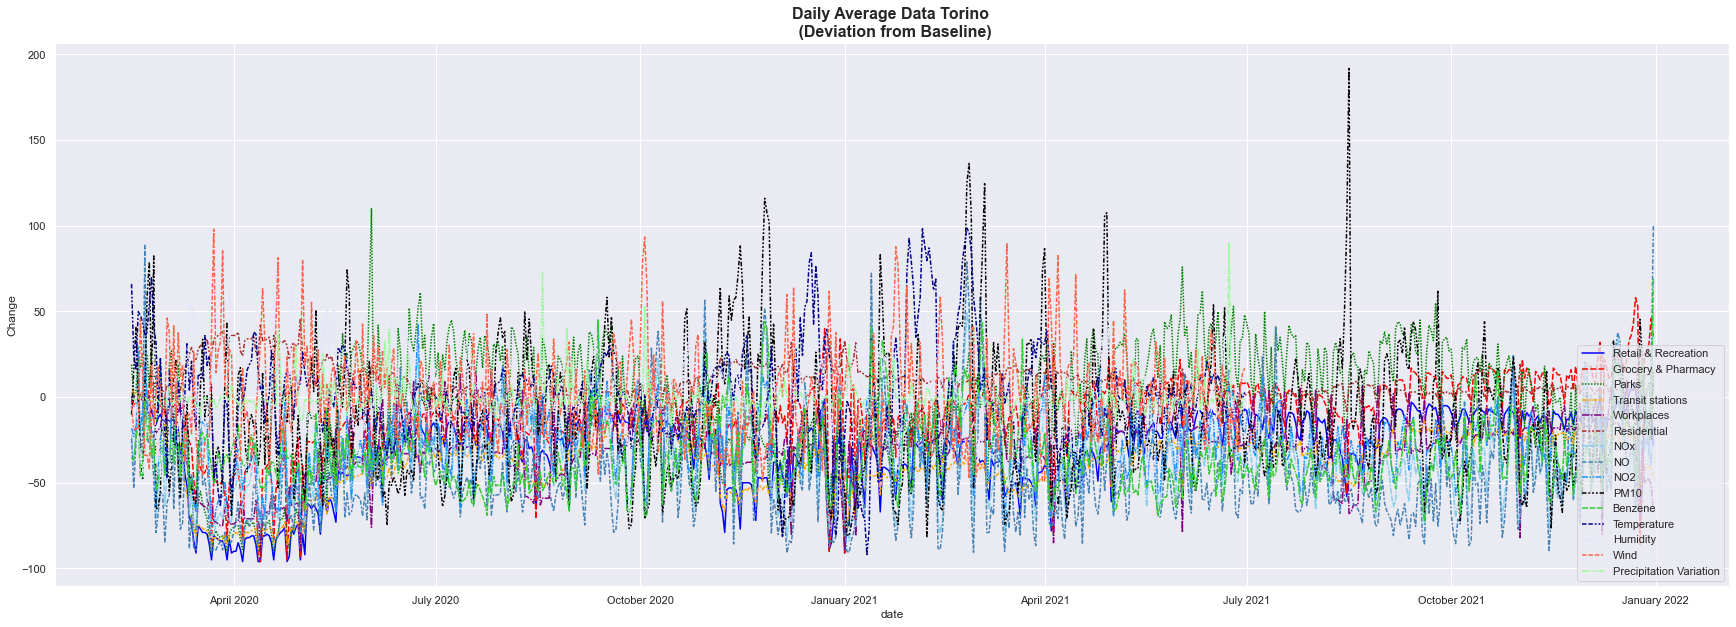

<Figure size 432x288 with 0 Axes>

In [177]:
palette = ["blue","red","green","orange","purple","brown","skyblue","steelblue", "dodgerblue","black", "limegreen",
 'darkblue', 'lavender','tomato','palegreen']
fig, ax = plt.subplots(figsize=(30, 10))
chart = sns.lineplot(data=merged_data, palette=palette)
plt.ylabel('Change')
plt.title("Daily Average Data Torino \n (Deviation from Baseline)",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
plt.legend(loc='lower right')
ax.xaxis.set_major_formatter(dates.DateFormatter("%B %Y"))
plt.figure()

## NOx vs Mobility

<Figure size 432x288 with 0 Axes>

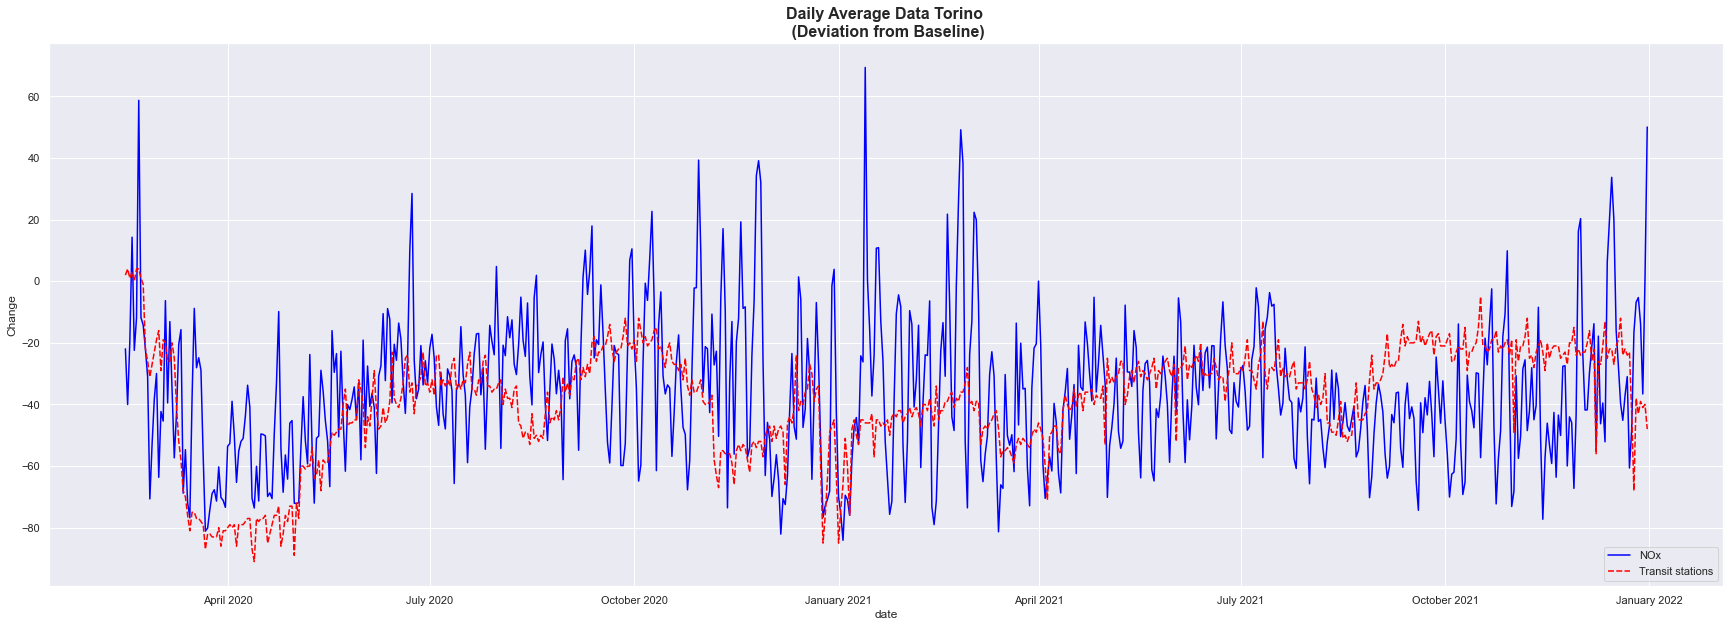

<Figure size 432x288 with 0 Axes>

In [178]:
palette = ["blue","red"]
fig, ax = plt.subplots(figsize=(30, 10))
chart = sns.lineplot(data=merged_data[['NOx','Transit stations']], palette=palette)
plt.ylabel('Change')
plt.title("Daily Average Data Torino \n (Deviation from Baseline)",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
plt.legend(loc='lower right')
ax.xaxis.set_major_formatter(dates.DateFormatter("%B %Y"))
plt.figure()


## PM10 vs Transit

<Figure size 432x288 with 0 Axes>

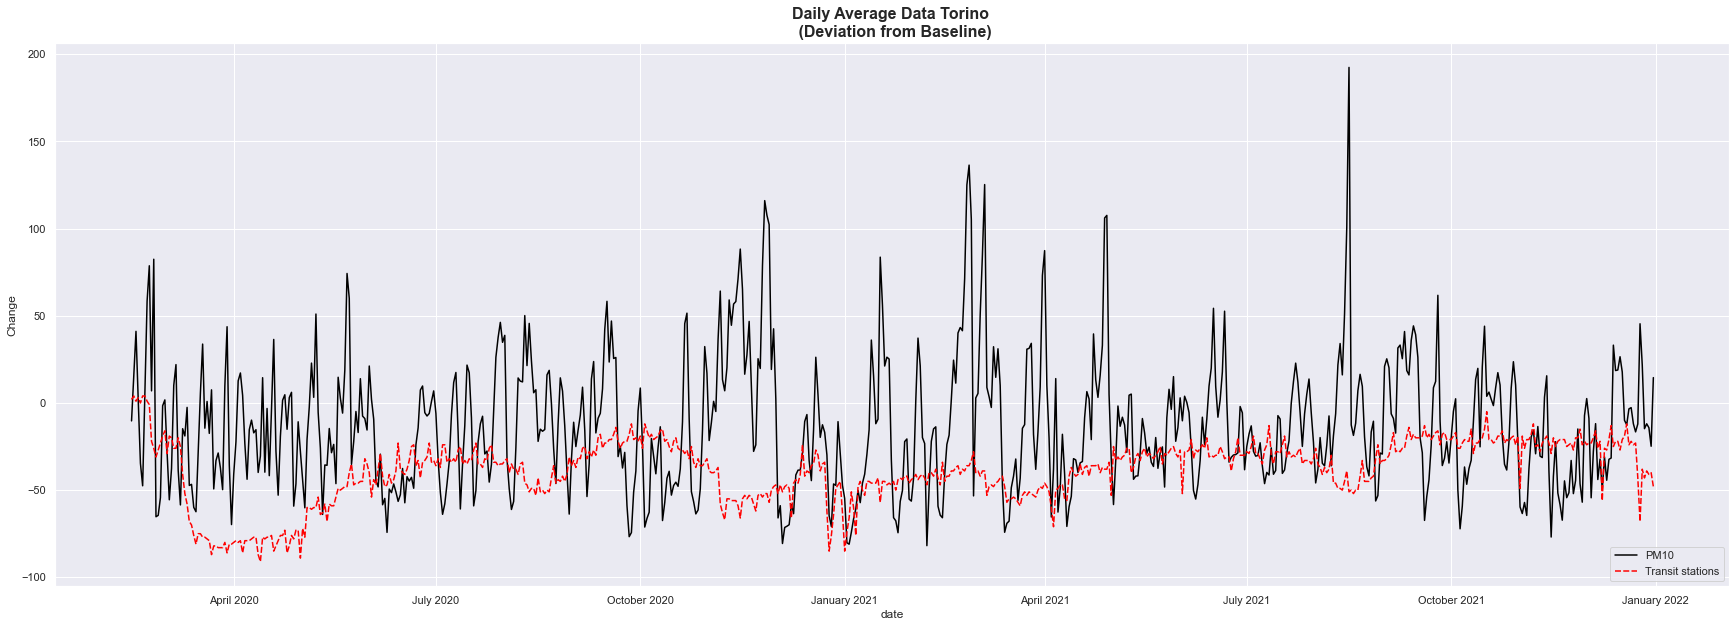

<Figure size 432x288 with 0 Axes>

In [179]:
palette = ["black","red"]
fig, ax = plt.subplots(figsize=(30, 10))
chart = sns.lineplot(data=merged_data[['PM10','Transit stations']], palette=palette)
plt.ylabel('Change')
plt.title("Daily Average Data Torino \n (Deviation from Baseline)",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
plt.legend(loc='lower right')
ax.xaxis.set_major_formatter(dates.DateFormatter("%B %Y"))
plt.figure()


## PM10 vs Precipitation

<Figure size 432x288 with 0 Axes>

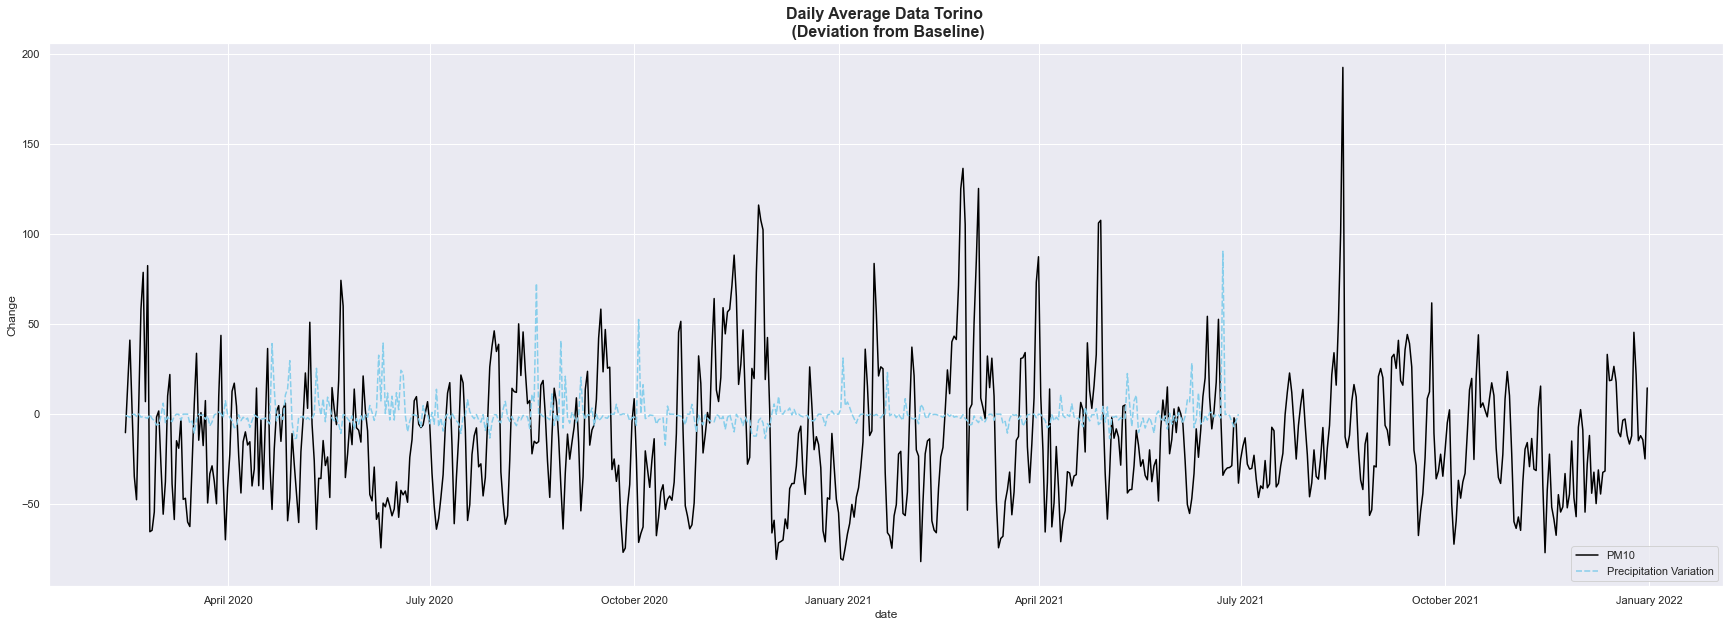

<Figure size 432x288 with 0 Axes>

In [180]:
palette = ["black","skyblue"]
fig, ax = plt.subplots(figsize=(30, 10))
chart = sns.lineplot(data=merged_data[['PM10','Precipitation Variation']], palette=palette)
plt.ylabel('Change')
plt.title("Daily Average Data Torino \n (Deviation from Baseline)",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
plt.legend(loc='lower right')
ax.xaxis.set_major_formatter(dates.DateFormatter("%B %Y"))
plt.figure()


### Save CSV file

In [181]:
merged_data.reset_index(inplace=True)

#Unpivot a DataFrame from wide to long format
csv_data = merged_data.melt(id_vars="date", value_vars=['Retail & Recreation','Grocery & Pharmacy','Parks','Transit stations','Workplaces','Residential','NOx','NO','NO2','PM10','Benzene','Wind','Temperature','Humidity','Precipitation Variation'],
      var_name='type', value_name='value', ignore_index=True)

csv_data.sort_values(by=['date'])

#remove nan value
# csv_data.dropna(inplace=True)
csv_data = csv_data.fillna(0)
#Save data to CSV file
csv_data.to_csv('data/Output/turin_daily_deviation.csv')
